# Generate  simulations of a SED including atmospheric effect and detector effect


- Author : Sylvie Dagoret-Campagne
- Date of creation :  July 4th 2016


- Original SED can be found here :

ftp://ftp.stsci.edu/cdbs/current_calspec/



In [192]:
import numpy as np

%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


In [193]:
from astropy.io import fits

In [194]:
import os

In [195]:
from scipy.interpolate import UnivariateSpline

## Calspec SED

In [196]:
path_sed='calspec'
basefile_sed='hd163466_stis_003.fits'
obj_name='hd163466'
airmass='1.1'
night_name='20160509-y3'

In [197]:
path_sed='calspec'
basefile_sed='hd163466_stis_003.fits'
obj_name='hd163466'
airmass='1.1'
night_name='20160509-y4'

In [198]:
file_sed=os.path.join(path_sed,basefile_sed)

In [199]:
hdulist=fits.open(file_sed)
#hdulist.info()

In [200]:
table_data=hdulist[1].data

In [201]:
wavelength_sed=(table_data.field('WAVELENGTH'))/10.   # convert the wavelength into nm
flux_sed=table_data.field('FLUX')

In [202]:
selected_indexes=np.where(np.logical_and(wavelength_sed>=0, wavelength_sed<1500.))

In [203]:
wavelength_sed=wavelength_sed[selected_indexes]
flux_sed=flux_sed[selected_indexes]

## Detector

In [204]:
path_ccd='detectoreffect'
basefile_ccd='transmissions-LSST.dat'

In [205]:
file_ccd=os.path.join(path_ccd,basefile_ccd)

In [206]:
df=pd.read_csv(file_ccd,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [207]:
wavelength_ccd=df['wl']
efficiency_ccd=df['Tccd']/100.
transmission_opt=df['Topt']/100.

In [208]:
TOPT=np.interp(wavelength_sed,wavelength_ccd,transmission_opt)
TCCD=np.interp(wavelength_sed,wavelength_ccd,efficiency_ccd)

### Filters Y3 and Y4

In [209]:
file_design='detectoreffect/FilterFinalDesignSpreadsheet23DEC2010_V1_SDC2016.xls'

#### Y3

In [210]:
y3_selected_cols=[2,3,4,4,6,7,8,9,10]
y3_header=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

In [211]:
dfy3=pd.read_excel(open(file_design,'rb'), sheetname=6,parse_cols=y3_selected_cols,skiprows=y3_header)

In [212]:
wl_y3=dfy3['Wavelength (nm)']
flt_y3=dfy3['y3 Filter Mean Transmission over centered 10nm interval (%)']
flt_y3=flt_y3/100.

In [213]:
TY3=np.interp(wavelength_sed,wl_y3,flt_y3)

#### Y4

In [214]:
y4_selected_cols=[2,3,4,4,6,7,8,9,10]
y4_header=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

In [215]:
dfy4=pd.read_excel(open(file_design,'rb'), sheetname=7,parse_cols=y4_selected_cols,skiprows=y4_header)

In [216]:
wl_y4=dfy4['Wavelength (nm)']
flt_y4=dfy4['y4 Filter Mean Transmission over centered 10nm interval (%)']
flt_y4=flt_y4/100.

In [217]:
TY4=np.interp(wavelength_sed,wl_y4,flt_y4)

## Loop on atmospheric files

In [218]:

root_file='UVSPEC_REPTRAN_SOLAR_ALT22_COARSE_'
pre_file=['pwv05_','pwv10_','pwv15_','pwv20_','pwv25_','pwv30_','pwv35_','pwv40_',
          'pwv45_','pwv50_','pwv55_','pwv60_','pwv65_','pwv70_','pwv75_','pwv80_']
ext_file='.out'

In [219]:
path_atm='libradtran/monocam_2016-05-09-y3/afglus'
numstart=1
numstop=10

In [220]:
path_atm='libradtran/monocam_2016-05-09-y4/afglus'
numstart=1
numstop=8

In [221]:
NBPWV=len(pre_file)

In [222]:
file_indexes=np.arange(numstart,numstop+1)

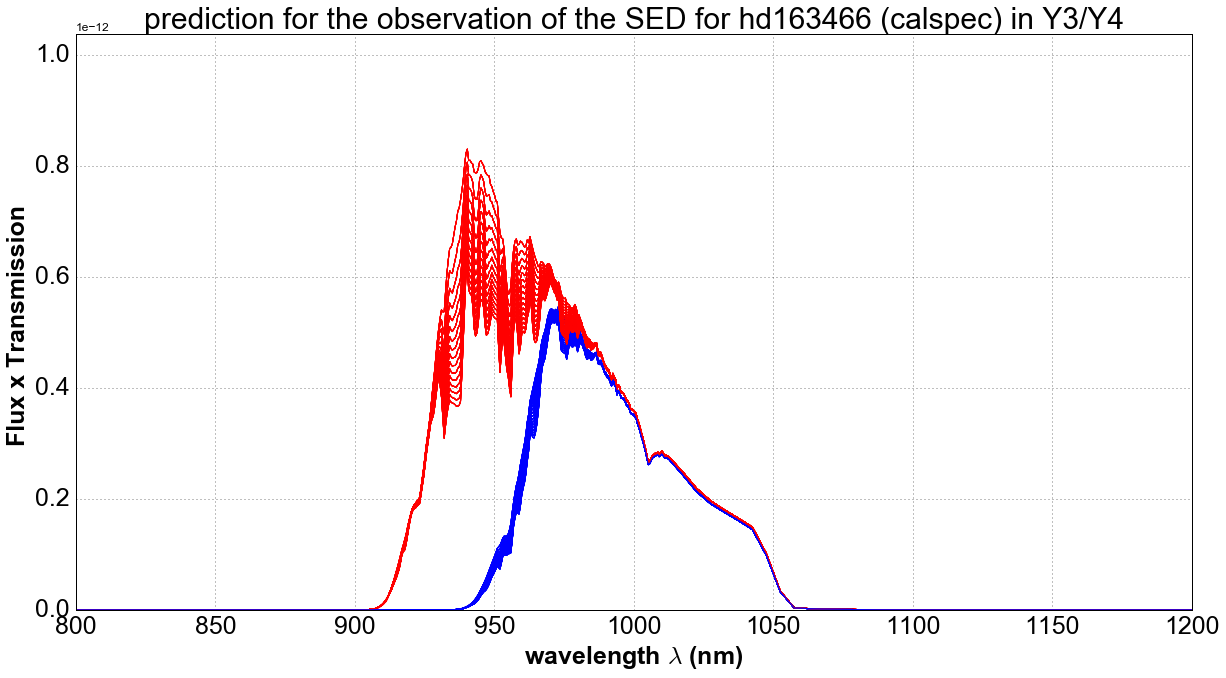

In [223]:
plt.figure(figsize=(20,10))

for idx,pre in enumerate(pre_file):    
    for index,fileindex in np.ndenumerate(file_indexes):    
        basefile_atm=root_file+pre+str(fileindex)+ext_file     # input file
        
        file_atm=os.path.join(path_atm,basefile_atm)

        atm_array=np.loadtxt(file_atm)
        wavelength_atm=atm_array[:,0] # in nm
        transmission_atm=atm_array[:,1]
    
        selected_wlindexes=np.where(np.logical_and(wavelength_atm>=0, wavelength_atm<1200.))
        wavelength_atm=wavelength_atm[selected_wlindexes]
        transmission_atm=transmission_atm[selected_wlindexes]
    
        TATM=np.interp(wavelength_sed,wavelength_atm,transmission_atm)
    
        SED1=flux_sed
        SED2=flux_sed*TCCD
        SED3=flux_sed*TCCD*TATM
        SED4=flux_sed*TCCD*TATM*TOPT
        SED5=flux_sed*TCCD*TATM*TOPT*TY3
        SED6=flux_sed*TCCD*TATM*TOPT*TY4
        #save the file

        tablefitsfile='SEDPred_'+obj_name+'_'+night_name+'_'+pre+str(fileindex)+'.fits'  # output file
    
        prim_hdr=fits.Header()
        prim_hdr['OBJ_NAME']=obj_name
        prim_hdr['UNITS']='wavelength in nm'
        prim_hdr['COMMENT']="Prediction of observable SED"
        primhdu=fits.PrimaryHDU(header=prim_hdr)
    
        col1 = fits.Column(name='WAVELENGTH', format='E', array=wavelength_sed)
        col2 = fits.Column(name='SEDcalspec', format='E', array=SED1)
        col3 = fits.Column(name='SEDxQE', format='E', array=SED2)
        col4 = fits.Column(name='SEDxQExATM', format='E', array=SED3)
        col5 = fits.Column(name='SEDxQExATMxTopt', format='E', array=SED4)
        col6 = fits.Column(name='SEDxQExATMxToptxY3', format='E', array=SED5)
        col7 = fits.Column(name='SEDxQExATMxToptxY4', format='E', array=SED6)
    
        cols = fits.ColDefs([col1, col2,col3,col4,col5,col6,col7])     # definition of the column
        tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    
        thdulist = fits.HDUList([primhdu, tbhdu])
        thdulist.writeto(tablefitsfile,clobber=True)
           
        plt.plot(wavelength_sed,SED6,color='r')
        plt.plot(wavelength_sed,SED5,color='b')
        
plt.xlim(800,1200.)
plt.ylim(0,SED5.max()*2)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.title('prediction for the observation of the SED for hd163466 (calspec) in Y3/Y4',fontsize=30)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=25)
plt.ylabel('Flux x Transmission ',fontsize=25)